In [1]:
import numpy as np
import random as rng
import numpy.random as numRand
import optproblems
from optproblems import cec2005
from optproblems import *
import typing 
import matplotlib.pyplot as plt
import pandas as pd
# from matplotlib import cm
# from mpl_toolkits.mplot3d import axes3d

In [150]:
# mutation functions

# not actually used so I don't haev to comment it ;D
def bitFlip(genotype, flip_probability):
    p = flip_probability
    
    for i in range(len(genotype)):
        if p >= np.random.rand(1, 1):
            genotype[i] = not(genotype[i])
    return genotype
#end

# gaussian convolution
# Add gaussian-distributed random numbers to a random selection of values from the genotype
# variance: variance of the distribution random numbers will be generated from
# min: minimum number genotype's values can be 
# max: maximum number genotype's values can be
# noise_probability: probability that gaussian number will be added a value in the genotype
def gaussianConvolution(genotype, variance=1, min = -100, max = 100, noise_probability=0.5):
    p = noise_probability #probability of adding noise to a genotype value
    var = variance        #variance of the gaussian distribution which will be added to a genotype val
    mu = 0                #mean of the normal distribution
    genotype = np.array(genotype)
    
    for i in range(len(genotype)): #for every genotype member
        # if the noise probability is greater than a random number (between 0 and 1)
        if p >= np.random.rand(1, 1): #a 1x1 array of random numbers (a.k.a a random number)
            #generate a random nnumber from a gaussian distribution
#             randy_num = rng.normalvariate(mu, var)
#             np.clip(randy_num, min, max, randy_num)
            
#             #until (current genotype value + randy_num) is between min and max
#             while not (min <= genotype[i] + randy_num <= max):
#                 randy_num = rng.normalvariate(mu, var)
#             #end
            
            genotype[i] = (genotype[i] + rng.normalvariate(mu, var)) #update current value from genotype
        #end
        np.clip(genotype, min, max, genotype)
    return genotype.tolist()
#end

mutate_functions = {"bit flip":bitFlip, "g convolve":gaussianConvolution}

In [3]:
# test mutation

pop = np.array([2, 2, 2, 2, 1, 1, 1, 1], dtype="float")
mut_pop = mutate_functions["g convolve"](pop, 1, 0.5)
mut_pop

array([2.        , 2.        , 1.45704955, 2.        , 1.73876524,
       1.        , 1.        , 1.46610396])

In [131]:
# recombination

# swap values between 2 vectors starting from a random index and ending at another random index
# (index circularly)
# vec_1: a vector
# vec_2: a vector
def twoPtCrossover(vec_1, vec_2):
    #TODO - implement
    
    #TODO handle unequal-length vecs
    #TODO handle empty vecs
    vec_1 = vec_1.copy()
    vec_2 = vec_2.copy()
    
    # choose a random integer (between bidx and pop length) and
    # swap vector values between that index and the vectors' ends
    cross_beg_idx = int(rng.uniform(0, len(vec_1)))
    cross_ed_idx = int(rng.uniform(cross_beg_idx, (cross_beg_idx + len(vec_1)))) # will index circularly so that we dont get overflows      
    
    # if crossover start is greater than first index 
    # (crossing from zero would just output the same 2 vectors in reverse order)
    if cross_beg_idx > 0:
        # swap the values
        for idx in range(cross_beg_idx, cross_ed_idx):
            list_ed = len(vec1)
            swap = vec_1[idx % list_ed] #store the value to be swapped
            vec_1[idx] = vec_2[idx % list_ed]
            vec_2[idx % list_ed] = swap #swap the value to be swapped
        #end
    #end
    
    return vec_1, vec_2
#end

#swap values between 2 vectors starting from a random index
#vec_1: a vector
#vec_2: a vector
def onePtCrossover(vec_1, vec_2):
    #TODO handle unequal-length vecs
    #TODO handle empty vecs
    vec_1 = vec_1.copy()
    vec_2 = vec_2.copy()
    
    # choose a random integer (between bidx and pop length) and
    # swap vector values between that index and the vectors' ends
    cross_beg_idx = int(rng.uniform(0, len(vec_1)))
    
    # if crossover start is greater than first index 
    # (crossing from zero would just output the same 2 vectors in reverse order)
    if cross_beg_idx > 0:
        # swap the values
        for idx in range(cross_beg_idx, len(vec_1)):
            swap = vec_1[idx] #store the value to be swapped
            vec_1[idx] = vec_2[idx]
            vec_2[idx] = swap #swap the value to be swapped
        #end
    #end
    return vec_1, vec_2
#end

recombine_fns = {"1-pt-crossover":onePtCrossover}

In [5]:
# test recombination
pop_1 = [4.0, 3.2, 1.0, 0.5, 6.2]
pop_2 = [10.0, 15.0, 12.2, 9.5, 5.0]

pop_3, pop_4 = onePtCrossover(pop_1, pop_2)

print(pop_3)
pop_4

[4.0, 3.2, 12.2, 9.5, 5.0]


[10.0, 15.0, 1.0, 0.5, 6.2]

In [147]:
#selection

# Assess a genotype's fitness score in relation to a given problem function
# In GA, allows GA to find genotypes with greatest fitness and "naturally select" them
# genotype: a potential solution
# problem: the solution will be assessed on the output it receives when applied to this problem
def assessFitness(genotype, problem):
    if genotype[0] == None:
        fitness = np.inf
    else:
        solution = Individual(genotype)
        problem.evaluate(solution)
        fitness = solution.objective_values
    #end
    
    return fitness
#end

# select the best genotype from the population according to a tournament process
# population: to select individuals from
# tournament_size: size of the group considered for selection
# problem: population members' fitness will be assessed according to their score on this problem
def tournamentSelect(population, tournament_size, problem, debug = False):
    t = tournament_size
    
    select_idx = int(rng.uniform(0, len(population)))
    best_idx = select_idx
    best = population[select_idx]
    
    # for every population element between second and "tournament size"...
    for i in range(0, t):
        # choose a "next" at random from pop
        select_idx = int(rng.uniform(0, len(population)))
        next = population[select_idx]
        if debug:
            print("Fighter: {}\t Fitness: {}".format(next, assessFitness(next, problem)))
        #end
        
        # if fitness of Next better than best...
        if assessFitness(next, problem) < assessFitness(best, problem):
            best = next
        #end
    #end
    
    return best
#end

# based on implementation from https://rocreguant.com/roulette-wheel-selection-python/2019/
# and, pseudo code from...

def rouletteWheelSelect(population, fitnesses):
    population_fitness = sum([fit for fit in fitnesses])
    
    genotype_probabilities = [fitnesses[i]/population_fitness for i in range(len(fitnesses))]
    # invert the probabilities to suit minimization by optimisation
    genotype_probabilities = 1 - np.array(genotype_probabilities)
    
    return rng.choice(population, p=genotype_probabilities)
#end

In [7]:
# test assessFitness()

print(assessFitness([-19.9, 50.35], problem = optproblems.Problem(cec2005.F1(2))))
print(assessFitness([18, -72], problem = optproblems.Problem(cec2005.F4(2))))
print(assessFitness([18, -72, 0, 0, 0, 0, 0, 0, 0, 0], problem = optproblems.Problem(cec2005.F4(10))))

-0.07734837999987576
-63.91566517774015
27815.650914503363


In [8]:
# test tournamentSelect()

population = [[-15, 13.9], [-13, 12], [-19.9, 50.35], [5, 50], [-15, 0], [-13, 42], [-3, 59], [4, -4], 
              [-13, 13], [15, 15], [-15, 13.9], [-19.9, 50.35], [-15, 13], [-15, 13], [-10, 0], 
              [-15, 13.9], [8, 2], [-19.9, 90.35], [6, 4], [-19.9, 10.35]]

king_of_fighters = tournamentSelect(population, 10, problem = optproblems.Problem(cec2005.F1(2)), debug =True)

print("King: {}".format(king_of_fighters))

Fighter: [-19.9, 50.35]	 Fitness: -0.07734837999987576
Fighter: [-15, 13.9]	 Fitness: 2166.0594816200005
Fighter: [-19.9, 90.35]	 Fitness: 915.9306516199995
Fighter: [-19.9, 10.35]	 Fitness: 2283.9146516200003
Fighter: [-15, 13.9]	 Fitness: 2166.0594816200005
Fighter: [-13, 12]	 Fitness: 2441.91670162
Fighter: [-13, 42]	 Fitness: 527.9227016200002
Fighter: [6, 4]	 Fitness: 4617.16730162
Fighter: [-3, 59]	 Fitness: 868.5641016200002
Fighter: [-15, 13.9]	 Fitness: 2166.0594816200005
King: [-19.9, 50.35]


In [9]:
#copy eerything except a given element from a list
def copyExcept(copy_this, dont_copy_this):
    list_clone = list()
    for i in range(0, len(copy_this)):
        if copy_this[i] != dont_copy_this:
            list_clone.append(copy_this[i])
    #end
    
    return list_clone
#end

In [10]:
dont_copy = [3, 3]
test_pop = [[1, 1], [2, 2], dont_copy]
print(test_pop)

clone = copyExcept(test_pop, dont_copy)
print(clone)

[[1, 1], [2, 2], [3, 3]]
[[1, 1], [2, 2]]


In [12]:
# genetic algorithm
DFLT_PROBLEM_DIMENSIONS = 10
fit_hist = list()

#TODO docs
# generation_limit:
# population_size:
# problem_dimensions:
# problem:
# debug: should debug msgs be printed?
def geneticAlgorithm(generation_limit = 500, population_size = 100, problem_dimensions = DFLT_PROBLEM_DIMENSIONS, problem = optproblems.Problem(cec2005.F1(DFLT_PROBLEM_DIMENSIONS)), problem_min = -100, problem_max = 100, debug = False):
    # create population
    pop = list()
    for i in range(population_size):
        pop.append(list(numRand.rand(1, problem_dimensions)[0]))
    #end
    
    glob_best = None
    glob_best_fit = np.inf
    generation = 0
    
    # assess fitnesses and assign best until best is the ideal solution
    while generation < generation_limit:
        generation += 1
        best = None
        best_fit = np.inf
        fit_list = list()
        
        # find the most selectablw genotype in the generation
        for idx in range(0, population_size):
            fit_list.append(assessFitness(pop[idx], problem))
            if  fit_list[idx] < best_fit:
                best = pop[idx].copy()
                best_fit = fit_list[idx]
            #end
        #end
        
        if  best_fit < glob_best_fit:
            glob_best = best.copy()
            glob_best_fit = best_fit
        #end
        
        # create next generation (Q in the pseudo code)
        next_gen_pop = list()
        for i in range(int(population_size/2)):
            # select parents
            parent_1 = tournamentSelect(pop.copy(), int(len(pop)/2), problem)
            copy_pop = copyExcept(pop.copy(), parent_1)
            parent_2 = tournamentSelect(copy_pop, int(len(pop)/2), problem)
            
            # birth some babbies using crossover
            child_1, child_2 = onePtCrossover(parent_1, parent_2)
            
            # we need to calculate our gaussians in relation to the input range 
            # or problems with different ranges will very different evolution performance
            inpt_rng = (max + abs(min))
            var_scale = 1/200 #variance scalar because the varirance needs to be much smaller than the problem's input range
            next_gen_pop.append(mutate_functions["g convolve"](child_1, variance = inpt_rng*var_scale, min = problem_min, max = problem_max))
            next_gen_pop.append(mutate_functions["g convolve"](child_2, variance = inpt_rng*var_scale, min = problem_min, max = problem_max))
        #end
        
        fit_hist.append(best_fit)
        
        if debug:
            int_best = [int(g) for g in best]
            print("Best : {}    Best fit : {}    Gen {}/{}".format(int_best, best_fit, generation, generation_limit))
        #end
        
        pop = next_gen_pop.copy()
    #end
    
    return glob_best_fit
#end



In [155]:
# genetic algorithm
DFLT_PROBLEM_DIMENSIONS = 10
fit_hist = list()

#TODO docs
# generation_limit:
# population_size:
# problem_dimensions:
# problem:
# debug: should debug msgs be printed?
def elitistGA(generation_limit = 500, population_size = 100, problem_dimensions = DFLT_PROBLEM_DIMENSIONS, problem = optproblems.Problem(cec2005.F1(DFLT_PROBLEM_DIMENSIONS)), problem_min = -100, problem_max = 100, isElitist = False, elites = 0, debug = False):
    # create population
    pop = list()
    for i in range(population_size):
        pop.append(list(numRand.rand(1, problem_dimensions)[0]))
    #end
    
    glob_best = None
    glob_best_fit = np.inf
    generation = 0
    
    # assess fitnesses and assign best until best is the ideal solution
    while generation < generation_limit:
        generation += 1
        
        best = None
        best_fit = np.inf
        fit_list = list()
        
        # find the most selectablw genotype in the generation
        for idx in range(0, population_size):
            fit_list.append(assessFitness(pop[idx], problem))
            if  fit_list[idx] < best_fit:
                best = pop[idx].copy()
                best_fit = fit_list[idx]
            #end
        #end
        
        if  best_fit < glob_best_fit:
            glob_best = best.copy()
            glob_best_fit = best_fit
        #end
        
        # create next generation (Q in the pseudo code)
        next_gen_pop = list()
        
        if isElitist:
            # add elites to next gen
            for e in range(elites):
                elite = tournamentSelect(pop.copy(), int(len(pop)/2), problem)
                next_gen_pop.append(elite)
            #end
        #end
        
        for i in range(int(population_size/2 - elites/2)):
            # select parents
#             parent_1 = tournamentSelect(pop.copy(), int(len(pop)/2), problem)
#             copy_pop = copyExcept(pop.copy(), parent_1)
#             parent_2 = tournamentSelect(copy_pop, int(len(pop)/2), problem)
            parent_1 = rouletteWheelSelect(population, fit_list.copy())
            parent_2 = rouletteWheelSelect(population, fit_list.copy())
            
            # birth some babbies using crossover
            child_1, child_2 = onePtCrossover(parent_1, parent_2)
            
            # we need to calculate our gaussians in relation to the input range 
            # or problems with different ranges will very different evolution performance
            inpt_rng = (max + abs(min))
            var_scale = 1/200 #variance scalar because the varirance needs to be much smaller than the problem's input range
            next_gen_pop.append(mutate_functions["g convolve"](child_1, variance = inpt_rng*var_scale, min = problem_min, max = problem_max))
            next_gen_pop.append(mutate_functions["g convolve"](child_2, variance = inpt_rng*var_scale, min = problem_min, max = problem_max))
        #end
        
        fit_hist.append(best_fit)
        
        if debug:
            int_best = [int(g) for g in best]
            print("Best : {}    Best fit : {}    Gen {}/{}".format(int_best, best_fit, generation, generation_limit))
        #end
        
        pop = next_gen_pop.copy()
    #end
    
    return glob_best_fit
#end

In [30]:
fit_hist = list()
gens = 500
pop_size = 100
dims = 10
prob = optproblems.Problem(cec2005.F12(dims))
min = -np.pi
max = np.pi
b_elitism = False
elite_num = 0

fitness = elitistGA(generation_limit = gens, population_size = pop_size, problem_dimensions = dims, problem = prob, problem_min = min, problem_max = max, isElitist = b_elitism, elites = elite_num)


Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation leng

Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation len

Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation leng

Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation len

Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation len

Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation len

Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation len

Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation len

Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation leng

Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation len

Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation len

Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation leng

Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation len

Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation leng

Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation len

Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation leng

Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation len

Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation len

Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation leng

Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation len

Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation len

Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation len

Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation leng

Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation len

Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation len

Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation len

Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation len

Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation leng

Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation len

Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation len

Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation leng

Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation len

Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation len

Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation len

Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation leng

Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation len

Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation leng

Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation leng

Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation len

Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation leng

Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation len

Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation len

Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation leng

Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation len

Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation leng

Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation len

Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation len

Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation leng

Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation len

Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation len

Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation len

Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation len

Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation len

Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation len

Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation len

Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation len

Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation len

Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation len

Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation leng

Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation len

Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation leng

Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation len

Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation len

Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation leng

Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation len

Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation len

Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation leng

Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation len

Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation leng

Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation len

Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation leng

Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation len

Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation len

Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation leng

Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation len

Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation leng

Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation length : 74
Next generation length : 76
Next generation length : 78
Next generation length : 80
Next generation length : 82
Next generation length : 84
Next generation length : 86
Next generation length : 88
Next generation length : 90
Next generation length : 92
Next generation length : 94
Next generation length : 96
Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation len

Next generation length : 98
Next generation length : 100
Next generation length : 10
Next generation length : 10
Next generation length : 12
Next generation length : 14
Next generation length : 16
Next generation length : 18
Next generation length : 20
Next generation length : 22
Next generation length : 24
Next generation length : 26
Next generation length : 28
Next generation length : 30
Next generation length : 32
Next generation length : 34
Next generation length : 36
Next generation length : 38
Next generation length : 40
Next generation length : 42
Next generation length : 44
Next generation length : 46
Next generation length : 48
Next generation length : 50
Next generation length : 52
Next generation length : 54
Next generation length : 56
Next generation length : 58
Next generation length : 60
Next generation length : 62
Next generation length : 64
Next generation length : 66
Next generation length : 68
Next generation length : 70
Next generation length : 72
Next generation len

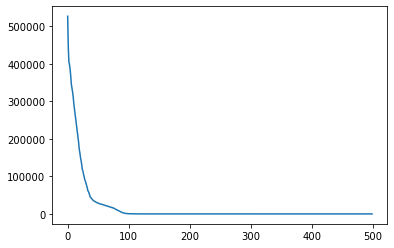

In [31]:
plt.plot(range(0, gens), fit_hist[0:gens])

In [156]:
fit_hist = list()
gens = 500
pop_size = 100
dims = 10
prob = optproblems.Problem(cec2005.F12(dims))
min = -np.pi
max = np.pi
b_elitism = False
elite_num = 0

gen_list = np.array(range(1, gens+1))
test_frame = pd.DataFrame(data=None, index=gen_list)
results_name = "results_f12"

num_tests = 2
for test in range(1, num_tests+1):
    print("Test : {}".format(test))
    fit_hist = list()
    col_header = "fit " + str(test)
    fitness = elitistGA(generation_limit = gens, population_size = pop_size, problem_dimensions = dims, problem = prob, problem_min = min, problem_max = max, isElitist = b_elitism, elites = elite_num) 
    test_frame[col_header] = np.array(fit_hist).T
#end

print("Done")

Test : 1


TypeError: choice() got an unexpected keyword argument 'p'

In [154]:
summary_frame = pd.DataFrame(columns=test_frame.columns)
summary_frame = summary_frame.append(test_frame.loc[1], ignore_index = True)
summary_frame = summary_frame.append(test_frame.loc[10], ignore_index = True)
gen_list = [1, 10]

for i in range(100, gens + 1, 100):
    summary_frame = summary_frame.append(test_frame.loc[i], ignore_index = True)
    gen_list.append(i)
#end

summary_frame["Gen"] = gen_list
cols = summary_frame.columns.tolist()
cols = cols[-1:] + cols[:-1]
summary_frame = summary_frame[cols]

summary_frame

,Gen,fit 1,fit 2,fit 3,fit 4,fit 5
0,1,491716.847593,566343.847588,574852.571254,519429.043659,445681.234307
1,10,309386.082643,368407.845257,303760.352056,342879.202771,330354.381738
2,100,5508.813594,15313.491720,16552.249975,-66.727273,666.189935
3,200,-433.248750,5620.162212,5710.673702,-431.120415,-427.565130
4,300,-427.011554,5291.610749,4933.652715,-429.347845,-424.799716
5,400,-431.710719,-163.689584,-214.990704,-422.150826,-441.021548
6,500,-431.381354,-234.212957,-227.890844,-430.666629,-439.223083


In [127]:
test_frame.to_csv("{}_elite.csv".format(results_name))
summary_frame.to_csv("{}_elite_summary.csv".format(results_name))

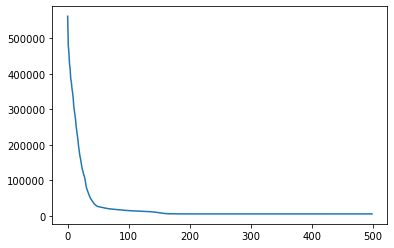

In [128]:
col = "fit 1"
plt.plot(range(0, len(test_frame[col])), test_frame[col])